<a href="https://colab.research.google.com/github/leilaabdel/mammogram-compression-representation/blob/master/notebooks/variational_autoencoder_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Fri Nov 27 19:53:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# import the necessary packages
import h5py
import tensorflow
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import numpy as np
import tensorflow as tf
import os
import cv2

In [4]:
# import the necessary packages
import h5py
import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Layer
from keras.layers import Reshape
from keras.layers import Input
from keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import numpy as np

# Load the Data

In [5]:
ROOT = '/content/drive/MyDrive/Masters-Program/courses/ece-638-digital-image-processing/FINAL-PROJECT'
DATA_ROOT = '/content/drive/MyDrive/Machine-Learning-Projects/ddsm-updated'
VIEW = "MLO"
ABNORMALITY = "mass"
HDF5_PATH = f"{DATA_ROOT}/HDF5_datasets/ddsm-{ABNORMALITY}-preprocessed-{VIEW}.h5"


In [6]:
f = h5py.File(HDF5_PATH, 'r')
f.keys()

<KeysViewHDF5 ['train-breast_density', 'train-mass_margins', 'train-mass_shape', 'train-pathology', 'train-raw-imgs', 'train-roi', 'train-roi_mask', 'train-side']>

In [7]:
x_train = f['train-raw-imgs']
x_train.shape

(637, 1024, 1024)

# Set Checkpoint Path

In [8]:
checkpoint_file = "weights-improvement-{epoch:02d}-{reconstruction_loss:.2f}.hdf5"
CHECKPOINT_PATH = f"{ROOT}/VAE-minimize-reconstruction/BEST-VAE-{checkpoint_file}"

os.makedirs(f"{ROOT}/VAE-minimize-reconstruction/" , exist_ok=True)

# Visulize Some Samples

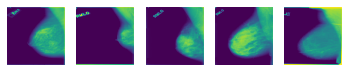

In [9]:
NUM_TO_VISUALIZE = 5
random_indices = np.random.randint(0 , len(x_train) , size=NUM_TO_VISUALIZE)
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  plt.imshow(x_train[random_indices[i]])



# Convolutional VAE 



In [10]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
class ConvVAE:
  @staticmethod
  def build(width, height, depth, filters=(32, 64), latentDim=16):
    inputShape = (height, width, depth)
    chanDim = -1
    # define the input to the encoder
    inputs = Input(shape=inputShape)
    x = inputs
    # loop over the number of filters
    for f in filters:
      # apply a CONV => RELU => BN operation
      x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chanDim)(x)
    # flatten the network and then construct our latent vector
    volumeSize = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latentDim)(x)
    z_mean = Dense(latentDim, name="z_mean")(latent)
    z_log_var = Dense(latentDim, name="z_log_var")(latent)
    z = Sampling()([z_mean, z_log_var])
    # build the encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")




    # start building the decoder model which will accept the
    # output of the encoder as its inputs
    latentInputs = Input(shape=(latentDim,))
    x = Dense(np.prod(volumeSize[1:]))(latentInputs)
    x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
    # loop over our number of filters again, but this time in
    # reverse order
    for f in filters[::-1]:
      # apply a CONV_TRANSPOSE => RELU => BN operation
      x = Conv2DTranspose(f, (3, 3), strides=2,
        padding="same")(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chanDim)(x)


      # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)
    # build the decoder model
    decoder = Model(latentInputs, outputs, name="decoder")
    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)),
      name="autoencoder")
    # return a 3-tuple of the encoder, decoder, and autoencoder
    return (encoder, decoder, autoencoder)
    

In [12]:
class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        encoder,
        decoder, 
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 1024 * 1024
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self , inputs):
      return


In [13]:
# construct our dataset
x_train = f['train-raw-imgs']
y_train = f['train-pathology']
y_train = np.asarray(y_train)
x_train = np.expand_dims(x_train , 3)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [14]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")

# initialize the number of epochs to train for and batch size
EPOCHS = 1000
BS = 10

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=True,
    monitor='reconstruction_loss',
    mode='min',
    save_best_only=True)

(encoder, decoder, _) = ConvVAE.build(x_train.shape[1], x_train.shape[2], x_train.shape[3])
opt = Adam(lr=1e-5)
vae = VariationalAutoEncoder(encoder, decoder)
vae.compile(optimizer=opt)
vae.evaluate(x_test , x_test , batch_size=16)
vae.load_weights(f'/content/drive/MyDrive/Masters-Program/courses/ece-638-digital-image-processing/FINAL-PROJECT/models-minimize-kl-div-reconstruction-loss/VAE-MODEL-1_1000_EPOCHS.h5')

[INFO] building autoencoder...
8/8 [==============================] - 0s 7ms/step - loss: 0.0000e+00


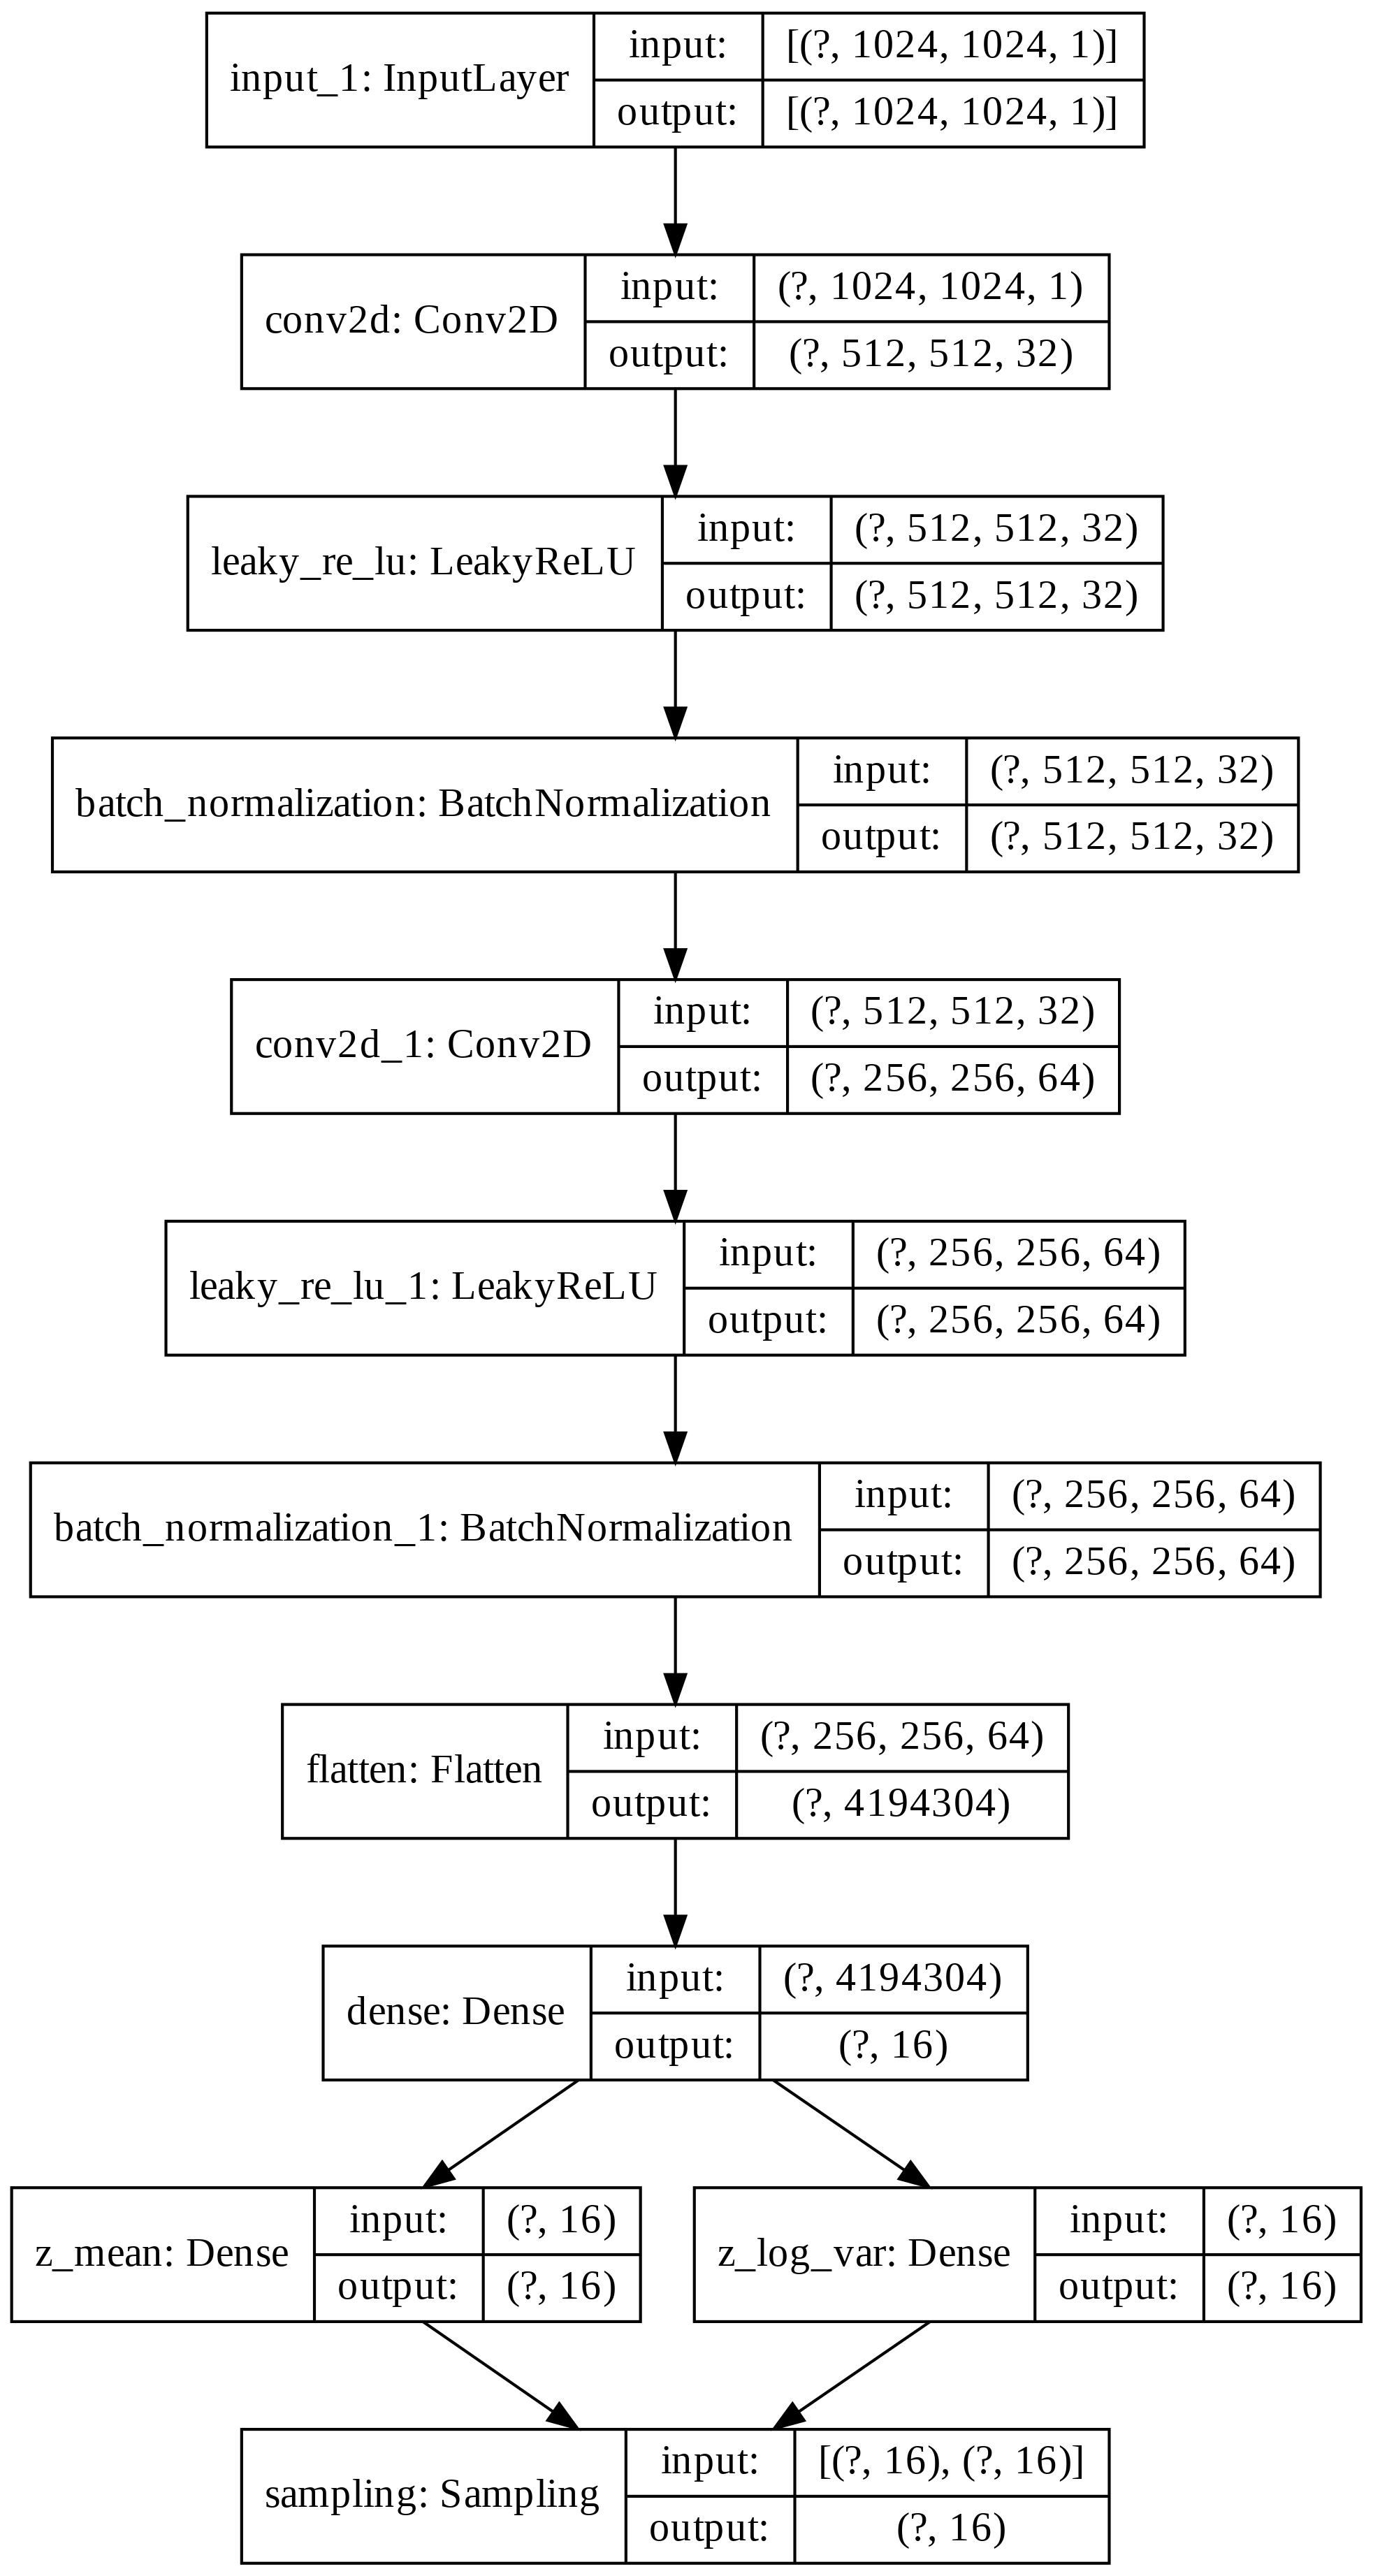

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(vae.encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=300)

In [ ]:
# train the convolutional autoencoder
# H = vae.fit(
# 	x_train, x_train,
# 	validation_data=(x_test, x_test),
# 	epochs=EPOCHS,
# 	batch_size=BS , callbacks=[model_checkpoint_callback])

Epoch 1/1000
51/51 [==============================] - 16s 315ms/step - loss: 723213.1575 - reconstruction_loss: 723028.2296 - kl_loss: 184.9278 - val_loss: 0.0000e+00
Epoch 2/1000
51/51 [==============================] - 14s 272ms/step - loss: 658544.9483 - reconstruction_loss: 652722.9928 - kl_loss: 5821.9568 - val_loss: 0.0000e+00
Epoch 3/1000
51/51 [==============================] - 14s 283ms/step - loss: 570320.9321 - reconstruction_loss: 555883.8299 - kl_loss: 14437.1008 - val_loss: 0.0000e+00
Epoch 4/1000
51/51 [==============================] - 14s 276ms/step - loss: 549196.3828 - reconstruction_loss: 520078.3287 - kl_loss: 29118.0571 - val_loss: 0.0000e+00
Epoch 5/1000
51/51 [==============================] - 12s 237ms/step - loss: 511099.5763 - reconstruction_loss: 496135.2007 - kl_loss: 14964.3774 - val_loss: 0.0000e+00
Epoch 6/1000
51/51 [==============================] - 14s 274ms/step - loss: 489189.3239 - reconstruction_loss: 474178.0312 - kl_loss: 15011.2924 - val_loss: 

# Plot Results

TypeError: ignored

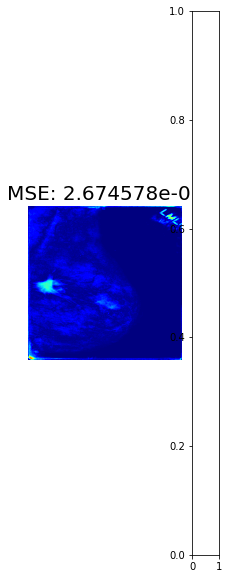

In [29]:
from sklearn.metrics import mean_squared_error
import sys
import cv2
z_sample_train = encoder.predict(x_train, batch_size=16)
x_decoded_train = decoder.predict(z_sample_train , batch_size=16)

z_sample_test = encoder.predict(x_test, batch_size=16)
x_decoded_test = decoder.predict(z_sample_test , batch_size=16)

plt.figure(figsize=(20,10))
NUM_TO_VISUALIZE = 5
random_indices = np.arange(0 , 5) #np.random.randint(0 , len(x_train) , size=NUM_TO_VISUALIZE)

for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  num = "{:e}".format(mean_squared_error(np.squeeze(x_train[random_indices[i]]) , np.squeeze(x_decoded_train[random_indices[i]])))
  plt.title(f"MSE: {num}" , fontsize=20)
  plt.imshow(np.abs(np.squeeze(x_decoded_train[i]) - np.squeeze(x_train[i])) , cmap='jet')
  plt.colorbar()

  break


# plt.figure(figsize=(20,10))
# for i in range(len(random_indices)):
#   plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
#   plt.axis('off')
#   plt.imshow(np.squeeze(x_train[random_indices[i]]))

# plt.figure(figsize=(20,10))
# random_indices = np.arange(0 , 5) #np.random.randint(0 , len(x_test) , size=NUM_TO_VISUALIZE)
# for i in range(len(random_indices)):
#   plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
#   plt.axis('off')
#   num = "{:e}".format(mean_squared_error(np.squeeze(x_test[random_indices[i]]) , np.squeeze(x_decoded_test[random_indices[i]])))
#   plt.title(f"MSE: {num}" , fontsize=20)
#   plt.imshow(np.abs(np.squeeze(x_decoded_test[i]) - np.squeeze(x_test[i])))


# plt.figure(figsize=(20,10))
# for i in range(len(random_indices)):
#   plt.subplot(1 , NUM_TO_VISUALIZE ,  i + 1)
#   plt.axis('off')
#   plt.imshow(np.squeeze(x_test[random_indices[i]]))

# plt.figure(figsize=(20,10))
# for i in range(len(random_indices)):
#   encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 85]
#   result, encimg = cv2.imencode('.jpg', x_train[i] * 255., encode_param)
#   decimg = cv2.imdecode(encimg, 0)
#   plt.subplot(1 , NUM_TO_VISUALIZE ,  i + 1)
#   num = "{:e}".format((mean_squared_error(np.squeeze(x_train[random_indices[i]]) , decimg / 255.)))
#   plt.title(f"MSE: {num}" , fontsize=20)
#   plt.axis('off')
#   plt.imshow(np.abs(np.squeeze(decimg) / 255. - np.squeeze(x_train[i])))


In [71]:
from sklearn.metrics import mean_squared_error
import sys
import cv2
z_sample_train = encoder.predict(x_train, batch_size=16)
x_decoded_train = decoder.predict(z_sample_train , batch_size=16)

z_sample_test = encoder.predict(x_test, batch_size=16)
x_decoded_test = decoder.predict(z_sample_test , batch_size=16)

plt.figure(figsize=(20,10))
NUM_TO_VISUALIZE = 5
random_indices = np.arange(0 , 5) #np.random.randint(0 , len(x_train) , size=NUM_TO_VISUALIZE)

for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  num = "{:e}".format(mean_squared_error(np.squeeze(x_train[random_indices[i]]) , np.squeeze(x_decoded_train[random_indices[i]])))
  plt.title(f"MSE: {num}" , fontsize=20)
  plt.imshow(np.squeeze(x_decoded_train[random_indices[i]]))


plt.figure(figsize=(20,10))
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  plt.imshow(np.squeeze(x_train[random_indices[i]]))

plt.figure(figsize=(20,10))
random_indices = np.arange(0 , 5) #np.random.randint(0 , len(x_test) , size=NUM_TO_VISUALIZE)
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE , i + 1)
  plt.axis('off')
  num = "{:e}".format(mean_squared_error(np.squeeze(x_test[random_indices[i]]) , np.squeeze(x_decoded_test[random_indices[i]])))
  plt.title(f"MSE: {num}" , fontsize=20)
  plt.imshow(np.squeeze(x_decoded_test[random_indices[i]]))


plt.figure(figsize=(20,10))
for i in range(len(random_indices)):
  plt.subplot(1 , NUM_TO_VISUALIZE ,  i + 1)
  plt.axis('off')
  plt.imshow(np.squeeze(x_test[random_indices[i]]))

plt.figure(figsize=(20,10))
for i in range(len(random_indices)):
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 85]
  result, encimg = cv2.imencode('.jpg', x_train[i] * 255., encode_param)
  decimg = cv2.imdecode(encimg, 0)
  plt.subplot(1 , NUM_TO_VISUALIZE ,  i + 1)
  num = "{:e}".format((np.abs(np.squeeze(x_train[random_indices[i]]) decimg / 255.) /  sys.getsizeof(encimg)))
  plt.title(f"MSE: {num}" , fontsize=20)
  plt.axis('off')
  plt.imshow(np.squeeze(x_train[i]))


75466

## JPEG Comparison

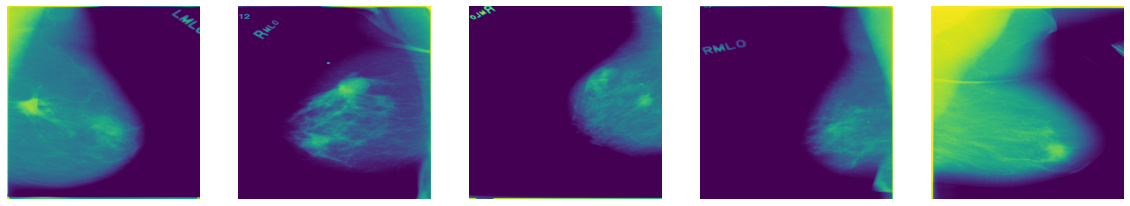

In [54]:
plt.figure(figsize=(20,10))
for i in range(5):
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90]
  result, encimg = cv2.imencode('.jpg', x_train[i] * 255., encode_param)
  decimg = cv2.imdecode(encimg, 0)
  plt.subplot(1 , NUM_TO_VISUALIZE ,  i + 1)
  plt.axis('off')
  plt.imshow(np.squeeze(x_train[i]))


In [76]:
z_sample = vae.encoder.predict(x_train , batch_size=16)
x_decoded = vae.decoder.predict(z_sample , batch_size=16)

In [86]:
z_sample[2].shape


(509, 16)

In [80]:
import pickle
print(ROOT)
os.makedirs(f"{ROOT}/data/pickles", exist_ok=True)
with open(f"{ROOT}/data/pickles/vae-predictions.pickle" , "wb") as f:
  pickle.dump((z_sample, x_decoded) , f)

/content/drive/MyDrive/Masters-Program/courses/ece-638-digital-image-processing/FINAL-PROJECT


## Print Sample Reconstructions

In [ ]:
z_sample = encoder.predict(x_test[0:16])
x_decoded = decoder.predict(z_sample)

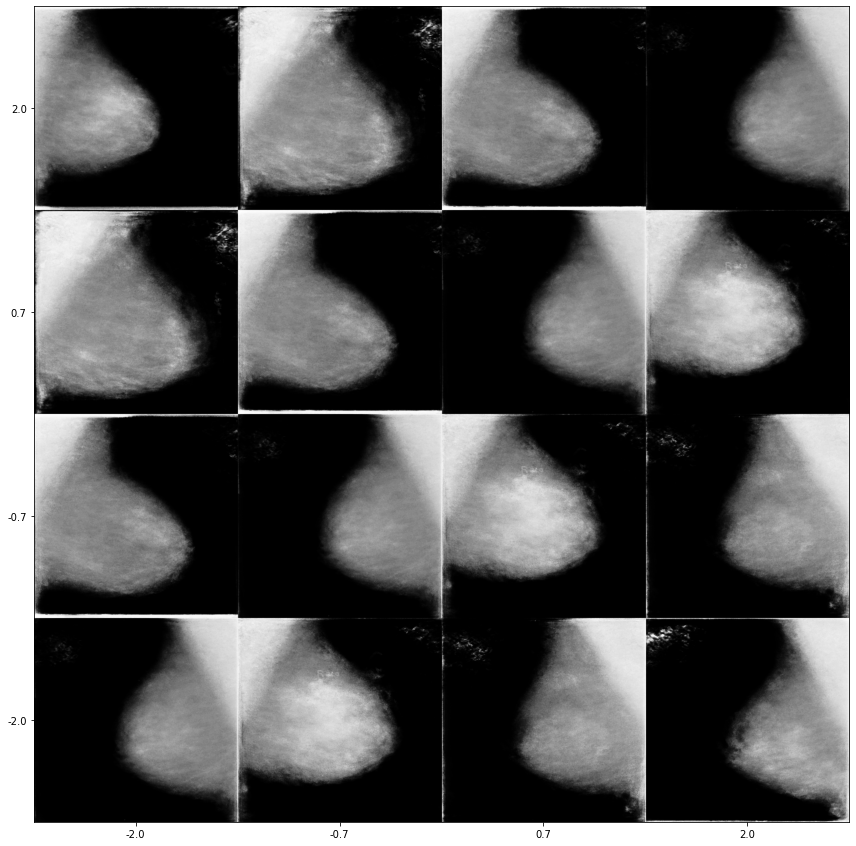

In [ ]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 4
    digit_size = 1024
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):   
            digit = x_decoded[i + j].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

In [ ]:
vae.save_weights('/content/drive/MyDrive/Masters-Program/courses/ece-638-digital-image-processing/FINAL-PROJECT/models-minimize-kl-div-reconstruction-loss/VAE-MODEL-1_1000_EPOCHS.h5')